# [활용] 자연어 처리 : 영화 리뷰 분석하기

In [17]:
import os
import re

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import utils

from keras.models import Sequential # keras 모델 만들기
from keras.layers import Dense # keras 레이어를 쌓기

from sklearn.feature_extraction.text import TfidfVectorizer # 문자열 벡터 변환
from sklearn.model_selection import train_test_split # 데이터를 train과 test로 분리하기

from bs4 import BeautifulSoup # 혹시 모를 html 태그 제거를 위해 사용할 예정

# 데이터 셋 다운

In [2]:
# 데이터 셋 다운 받기
data_set = tf.keras.utils.get_file(fname="imdb.tar.gz",
                                    origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                                    extract = True)

# 데이터 셋으로 데이터 프레임 만들기
##### 데이터 셋 구성
- data_set(폴더)
    - aclImdb(폴더)
        - train(폴더)
            - pos(폴더)
            - neg(폴더)
        - test(폴더)
            - pos(폴더)
            - neg(폴더)

##### 함수 정의하기

In [3]:
# 데이터 읽고 데이터 프레임 만들기 함수
def directory_data(directory):
    data={}
    data['review']=[]
    
    for file_path in os.listdir(directory):
        with open(os.path.join(directory, file_path), 'r', encoding='utf=8') as file: # 파일 읽기
            data['review'].append(file.read()) # data['review']에 내용 저장하기
    return pd.DataFrame.from_dict(data) # 데이터 프레임 반환하기

# 긍정, 부정 데이터 프레임 만들기
def make_data(directory):
    pos_df = directory_data(os.path.join(directory, 'pos')) # 긍정적 데이터 프레임
    neg_df = directory_data(os.path.join(directory, 'neg')) # 부정적 데이터 프레임
    
    pos_df['sentiment']=1
    neg_df['sentiment']=0
    
    return pd.concat([pos_df, neg_df])

##### Train, Test폴더 안에 데이터를 데이터 프레임 저장하기

In [4]:
train_df = make_data(os.path.join(os.path.dirname(data_set),"aclImdb","train"))
test_df = make_data(os.path.join(os.path.dirname(data_set),"aclImdb","test"))

##### 분리된 데이터 확인하기

In [5]:
test_df.head()

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


# 데이터 내용 분석하기

In [6]:
import matplotlib.pyplot as plt

In [7]:
reviews = list(train_df['review'])
tokenized_reviews = [r.split() for r in reviews] # 문장별 띄어쓰기를 기준으로 단어 분리해주기

review_len_by_words = [len(t) for t in tokenized_reviews] # 문장별 토큰별 길이값 저장
review_len_by_alphabet = [len(s.replace(" ",'')) for s in reviews] # 문장별 글자의 개수 저장

##### 시각화

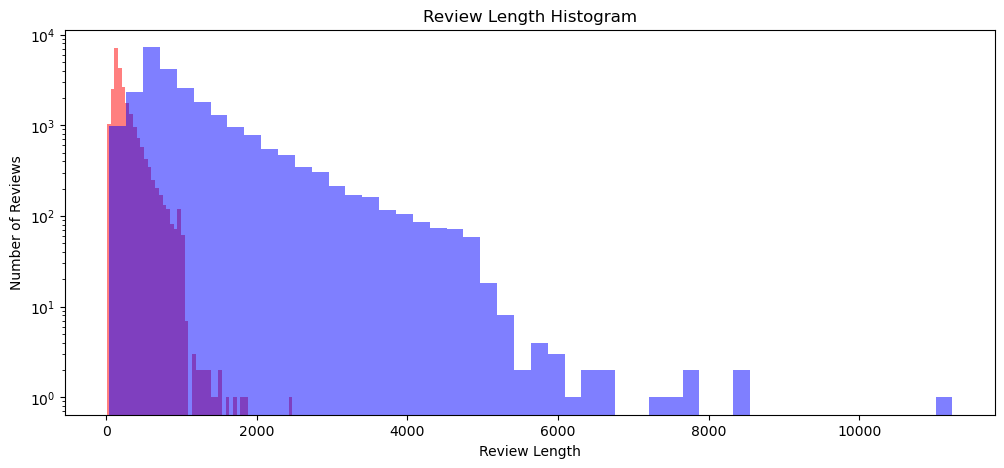

In [8]:
plt.figure(figsize=(12,5))

plt.hist(review_len_by_words, bins=50, alpha=0.5, color='r')
plt.hist(review_len_by_alphabet, bins=50, alpha=0.5, color='b')
plt.yscale('log')
plt.title("Review Length Histogram")
plt.xlabel('Review Length')
plt.ylabel("Number of Reviews")
plt.show()

##### 문장 분석

In [9]:
print(f"문장안 단어의 최대 갯수 : {np.max(review_len_by_words)}")
print(f"문장안 단어의 최대 갯수 : {np.min(review_len_by_words)}")
print(f"문장안 단어의 갯수의 평균 길이 : {np.mean(review_len_by_words)}")
print(f"문장안 단어의 갯수 표준편차 : {np.std(review_len_by_words)}")
print(f"문장안 단어 갯수의 중간값 : {np.median(review_len_by_words)}")
print(f"문장안 단어 갯수의 하위 10% 길이 : {np.percentile(review_len_by_words, 10)}")

문장안 단어의 최대 갯수 : 2470
문장안 단어의 최대 갯수 : 10
문장안 단어의 갯수의 평균 길이 : 233.7872
문장안 단어의 갯수 표준편차 : 173.72955740506566
문장안 단어 갯수의 중간값 : 174.0
문장안 단어 갯수의 하위 10% 길이 : 91.0


##### 분리된 train_df, test_df 데이터 프레임 합치기

In [19]:
imdb_pd = pd.concat([train_df, test_df])
imdb_pd

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1
...,...,...
12495,I occasionally let my kids watch this garbage ...,0
12496,When all we have anymore is pretty much realit...,0
12497,The basic genre is a thriller intercut with an...,0
12498,Four things intrigued me as to this film - fir...,0


##### 불용어 처리하기

In [24]:
from nltk.corpus import stopwords # 불용어 사전을 가져오기
import nltk

nltk.download('stopwords') # 불용어(stopwords)를 다운 받기
stop_words = set(stopwords.words('english')) # 영어로된 불용어 set로 만들기
stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

##### 불용어 처리 함수 정의하기

In [28]:
def preprocessing(review, remove_stopwords=True):
    review_text = BeautifulSoup(review, 'html5lib').get_text() # html 태크 제거
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    if remove_stopwords:
        words = review_text.split()
        words = [w for w in words if not w in stop_words]
        review_text = ' '.join(words)
    return review_text

In [34]:
list_reviews = list(imdb_pd['review'])

list_clean_reviews = [preprocessing(r) for r in list_reviews]

list_clean_reviews_df = pd.DataFrame({'review': list_clean_reviews,
                                     'sentiment': imdb_pd['sentiment']})

C:\Users\user\AppData\Local\Temp\ipykernel_13216\752022826.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review, 'html5lib').get_text() # html 태크 제거


In [38]:
display(imdb_pd)
display(list_clean_reviews_df)

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1
...,...,...
12495,I occasionally let my kids watch this garbage ...,0
12496,When all we have anymore is pretty much realit...,0
12497,The basic genre is a thriller intercut with an...,0
12498,Four things intrigued me as to this film - fir...,0


,review,sentiment
0,Bromwell High cartoon comedy It ran time progr...,1
1,Homelessness Houselessness George Carlin state...,1
2,Brilliant acting Lesley Ann Warren Best dramat...,1
3,This easily underrated film inn Brooks cannon ...,1
4,This typical Mel Brooks film It much less slap...,1
...,...,...
12495,I occasionally let kids watch garbage understa...,0
12496,When anymore pretty much reality TV shows peop...,0
12497,The basic genre thriller intercut uncomfortabl...,0
12498,Four things intrigued film firstly stars Carly...,0


##### 리뷰 벡터화 하기

In [43]:
list_reviews = list(list_clean_reviews_df['review'])
list_sentiments = list(list_clean_reviews_df['sentiment'])

In [44]:
encoder = TfidfVectorizer(max_features=5000)

# 이진분류기의 입력 값 : 리뷰를 수치 벡터화 하여 만든다.
X = encoder.fit_transform(list_reviews).toarray()
# 이진분류기의 출력 값 : sentiment를 기반하여 수치 벡터화 한 값을 넣는다.
y = np.array(list_sentiments) # 이미 1또는 0으로 벡터화 되어 있다.

##### Train, Test 데이터 나누기

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### keras 모델 만들기(인공신경망 만들기)

In [48]:
model =  Sequential()

model.add(Dense(1, activation='sigmoid')) # output layer

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')

##### 모델 학습하기

In [50]:
model.fit(X_train, y_train, epochs=50, verbose=1)

Epoch 1/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6912 - accuracy: 0.5612
Epoch 2/50
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6861 - accuracy: 0.6940
Epoch 3/50
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6813 - accuracy: 0.7536
Epoch 4/50
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6765 - accuracy: 0.7886
Epoch 5/50
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6718 - accuracy: 0.8036
Epoch 6/50
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6672 - accuracy: 0.8085
Epoch 7/50
1250/1250 [==============================] - 2s 2ms/step - loss: 0.6628 - accuracy: 0.8186
Epoch 8/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.6584 - accuracy: 0.8203
Epoch 9/50
1250/1250 [==============================] - 2s 1ms/step - loss: 0.6541 - accuracy: 0.8205
Epoch 10/50
1250/1250 [==============================] - 2s 2ms/step - loss: 0.649

##### 모델 평가하기

In [52]:
_,accuracy =  model.evaluate(X_test, y_test)
print(f"Accuracy : {accuracy}")

313/313 [==============================] - 1s 1ms/step - loss: 0.5364 - accuracy: 0.8444
Accuracy : 0.8443999886512756
